# Part III - D: Analyzing Changing Trends in Academia - Research Fields

## 4. Research Field  Dynamics
The MAG dataset links keywords and their corresponding field of study. Moreover, the dataset provides us with hierarchical data that links these research fields with their parent research fields in up to 4 levels (L0-L3). In this notebook, we will use the research field data to better understand how various fields of study change over time. First, as in previous notebooks, let's load the required Python packages.

In [1]:
from configs import *
import pandas as pd
import numpy as np
import altair as alt
alt.renderers.enable('notebook')
from visualization.visual_utils import *
import turicreate.aggregate as agg
FIELD_OF_STUDY_HIERARCHY = "%s/FieldOfStudyHierarchy.sframe" % SFRAMES_BASE_DIR

def normalize_features_dict(feature_dict, start_year):
    d = {}
    feature_dict = {(y - start_year):v for y,v in feature_dict.iteritems()}
    return feature_dict

def get_values_sum_by_year_dict(d, max_keys):
    d2 = {}
    for i in range(max_keys):
        d2[i] = sum([v for k,v in d.iteritems() if k <= i])
    return d2 

fields_sf = tc.load_sframe(EXTENDED_PAPERS_SFRAME)["Paper ID", "Paper publish year","Fields of study parent list names (L0)", 
                                                   "Fields of study parent list (L1)", "Fields of study parent list names (L1)",
                                                    "Fields of study parent list (L2)", "Fields of study parent list names (L2)",
                                                   "Ref Number", "Authors Number", "Total Citations by Year"]
fields_sf = fields_sf.rename({"Paper publish year": "Year"})
fields_sf = filter_sframe_by_years(fields_sf, 1850, 2010)
fields_sf = fields_sf[fields_sf["Fields of study parent list names (L0)"] != None]
fields_sf = fields_sf[fields_sf["Fields of study parent list names (L0)"].apply(lambda l: len(l) <= 10)] # remove papers that belong to more than 10 fields
fields_sf = fields_sf[fields_sf["Ref Number"] >= 5]
fields_sf.materialize()

/home/michael/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/michael/anaconda2/lib/python2.7/site-packages/entrypoints.py:171: DeprecationWarning: You passed a bytestring as `filenames`. This will not work on Python 3. Use `cp.read_file()` or switch to using Unicode strings across the board.
  cp.read(path)
/home/michael/anaconda2/lib/python2.7/importlib/__init__.py:37: DeprecationWarning: The vega3 module is deprecated. Use vega instead.
  __import__(name)


Let's create SFrame with the information on all L0 fields of study.

In [2]:
# Creating the L0 SFrame
l0_sf = fields_sf["Paper ID", "Year","Fields of study parent list names (L0)", "Authors Number", "Ref Number","Total Citations by Year"].stack("Fields of study parent list names (L0)", new_column_name="L0 Field")
l0_sf = l0_sf[l0_sf["L0 Field"] != None]
l0_sf.materialize()
l0_sf

Paper ID,Year,Authors Number,Ref Number,Total Citations by Year,L0 Field
7CFE299E,2009,4,14,"{'2015': 10.0, '2014':9.0, '2011': 3.0, '20 ...",Computer Science
7CFE299E,2009,4,14,"{'2015': 10.0, '2014':9.0, '2011': 3.0, '20 ...",Sociology
7CFE299E,2009,4,14,"{'2015': 10.0, '2014':9.0, '2011': 3.0, '20 ...",Mathematics
7CFE299E,2009,4,14,"{'2015': 10.0, '2014':9.0, '2011': 3.0, '20 ...",Engineering
59BEBE1C,2008,3,7,None,Mathematics
5873C011,2002,3,8,"{'2003': 1.0, '2006':3.0, '2007': 3.0, '20 ...",Computer Science
5C66D743,2009,2,9,"{'2015': 1.0, '2014':1.0} ...",Computer Science
5C66D743,2009,2,9,"{'2015': 1.0, '2014':1.0} ...",Chemistry
584D8787,2009,2,9,None,Computer Science
584D8787,2009,2,9,None,Sociology


Now let's explore how the various trends change in each research field, and we will add an SFrame which includes all the L1 research fields under Biology.

In [3]:
# Creating Biology L1 Sframe
f_sf = tc.load_sframe(FIELDS_OF_STUDY_SFRAME)
bio_id = f_sf[f_sf["Field of study name"] == "Biology"]["Field of study ID"][0]
h_sf = tc.load_sframe(FIELD_OF_STUDY_HIERARCHY)
h_sf = h_sf[h_sf["Parent field of study ID"] == bio_id]
bio_l1_ids = set(h_sf[h_sf["Child field of study level"] == "L1"]["Child field of study ID"])
bio_l1_names_sf = f_sf[f_sf["Field of study ID"].apply(lambda i: i in bio_l1_ids)]
bio_l1_dict = {r["Field of study ID"]: r["Field of study name"] for r in bio_l1_names_sf}

sf = fields_sf["Paper ID", "Year","Fields of study parent list names (L0)", "Fields of study parent list (L1)", "Authors Number", "Ref Number", "Total Citations by Year"]
l1_bio_sframe = sf[sf["Fields of study parent list (L1)"] != None]
l1_bio_sframe = l1_bio_sframe.stack("Fields of study parent list (L1)", new_column_name="L1 Field ID" )
l1_bio_sframe = l1_bio_sframe[l1_bio_sframe["L1 Field ID"].apply(lambda i: i in bio_l1_ids)]
l1_bio_sframe = l1_bio_sframe[l1_bio_sframe["L1 Field ID"] != None]
l1_bio_sframe["L1 Field"] = l1_bio_sframe["L1 Field ID"].apply(lambda i: bio_l1_dict[i])
l1_bio_sframe

Paper ID,Year,Fields of study parentlist names (L0) ...,Authors Number,Ref Number,Total Citations by Year,L1 Field ID
5873C011,2002,[Computer Science],3,8,"{'2003': 1.0, '2006':3.0, '2007': 3.0, '20 ...",0C19BFCD
59803B73,2006,"[Computer Science,Chemistry, Biology, ...",4,6,None,033D6521
5ED460A9,2009,"[Computer Science,Mathematics, Biology] ...",1,24,None,033D6521
7D75F10B,2008,"[Computer Science,Biology, Psychology] ...",2,10,None,0B170D53
8050742A,2008,"[Geology, Mathematics,Chemistry, Computer ...",2,20,None,033D6521
7F0016FA,2008,"[Computer Science,Medicine, Engineering, ...",3,5,"{'2015': 10.0, '2014':8.0, '2009': 1.0, '20 ...",033D6521
66CAB1C0,2002,"[Computer Science,Biology] ...",5,12,None,01207101
5F656C25,2009,"[Computer Science,Mathematics, Biology] ...",3,14,None,00640F05
5F656C25,2009,"[Computer Science,Mathematics, Biology] ...",3,14,None,033D6521
7D34E03C,2007,"[Computer Science,Physics, Mathematics, ...",3,5,"{'2015': 1.0, '2014':1.0, '2013': 1.0, '20 ...",0390D066


In [4]:
# Creating Biology L2 Sframe for 
gen_id = f_sf[f_sf["Field of study name"] == "Genetics"]["Field of study ID"][0]
h_sf = tc.load_sframe(FIELD_OF_STUDY_HIERARCHY)
h_sf = h_sf[h_sf["Parent field of study ID"] == gen_id]
gen_l2_ids = set(h_sf[h_sf["Child field of study level"] == "L2"]["Child field of study ID"])
gen_l2_names_sf = f_sf[f_sf["Field of study ID"].apply(lambda i: i in gen_l2_ids)]
gen_l2_dict = {r["Field of study ID"]: r["Field of study name"] for r in gen_l2_names_sf}

sf = fields_sf["Paper ID", "Year", "Fields of study parent list (L2)", "Authors Number", "Ref Number", "Total Citations by Year"]
l2_gen_sframe = sf[sf["Fields of study parent list (L2)"] != None]
l2_gen_sframe = l2_gen_sframe.stack("Fields of study parent list (L2)", new_column_name="L2 Field ID" )
l2_gen_sframe = l2_gen_sframe[l2_gen_sframe["L2 Field ID"].apply(lambda i: i in gen_l2_ids)]
l2_gen_sframe = l2_gen_sframe[l2_gen_sframe["L2 Field ID"] != None]
l2_gen_sframe["L2 Field"] = l2_gen_sframe["L2 Field ID"].apply(lambda i: gen_l2_dict[i])
l2_gen_sframe

Paper ID,Year,Authors Number,Ref Number,Total Citations by Year,L2 Field ID,L2 Field
5ED460A9,2009,1,24,None,027301DC,Epigenetics
8050742A,2008,2,20,None,0B470EAF,Genomics
5C698B6E,2005,2,8,None,027301DC,Epigenetics
8178E2AA,2006,5,7,None,093D58AF,Plant breeding
7C55455E,2006,6,6,"{'2007': 1.0, '2015':7.0, '2014': 7.0, '20 ...",0AE98092,Developmental biology
0856E642,2007,2,5,None,0B470EAF,Genomics
6FE194EC,2010,2,10,None,0B470EAF,Genomics
7FBD2C55,2008,3,19,None,027301DC,Epigenetics
81112497,2008,3,9,None,0B470EAF,Genomics
5AE8B595,2006,3,17,None,027301DC,Epigenetics


### 4.1  Number of Papers over Time

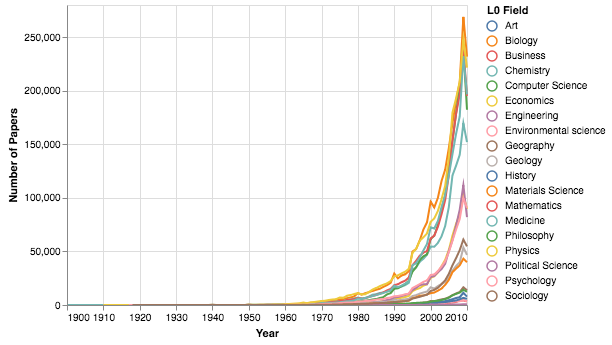

In [5]:
g = l0_sf.groupby(["Year", "L0 Field"], {"Number of Papers": agg.COUNT()})
df = g.to_dataframe()
df = df.sort_values(["L0 Field", "Year"])
chart = alt.Chart(df).mark_line().encode(
    alt.X('Year:Q', axis=alt.Axis(format='d'), scale=alt.Scale(zero=False)),
    alt.Y('Number of Papers:Q', scale=alt.Scale(zero=False)),
    color="L0 Field"
)
chart

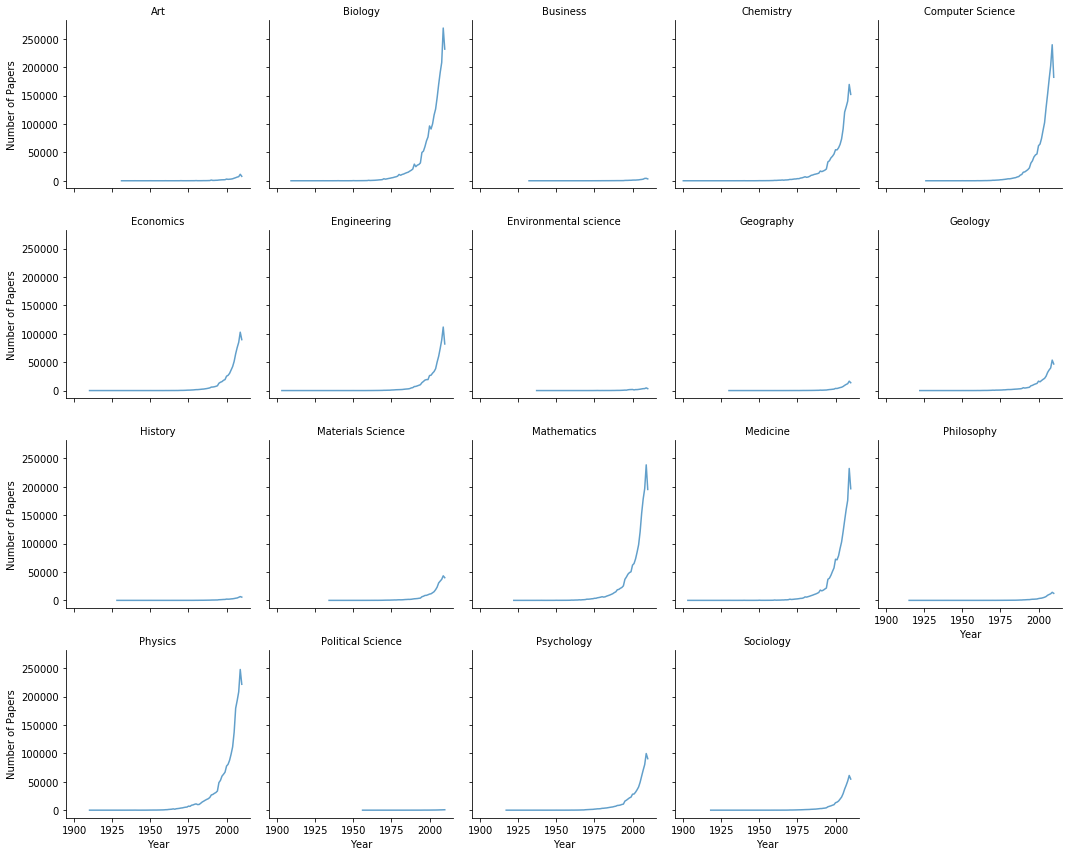

In [6]:
c = sns.FacetGrid(df, col="L0 Field", sharex=True, sharey=True, col_wrap=5)
c.map(plt.plot, "Year", "Number of Papers", alpha=.7).set_titles("{col_name}")

In [7]:
g[g["Year"] == 2010].sort("Number of Papers").print_rows(30)

+-----------------------+------+------------------+
|        L0 Field       | Year | Number of Papers |
+-----------------------+------+------------------+
|   Political Science   | 2010 |       728        |
|        Business       | 2010 |       3271       |
| Environmental science | 2010 |       3330       |
|        History        | 2010 |       5684       |
|          Art          | 2010 |       7800       |
|       Philosophy      | 2010 |      12369       |
|       Geography       | 2010 |      13784       |
|   Materials Science   | 2010 |      39906       |
|        Geology        | 2010 |      46771       |
|       Sociology       | 2010 |      54722       |
|      Engineering      | 2010 |      82027       |
|       Economics       | 2010 |      89621       |
|       Psychology      | 2010 |      90680       |
|       Chemistry       | 2010 |      152047      |
|    Computer Science   | 2010 |      182192      |
|      Mathematics      | 2010 |      195244      |
|        Med

We can observe that some fields such as Medicine, Physics, and CS had a surge in the number of papers, while other fields such as Political Science, Art, and Philosophy only had limited growth. Let's see what the number of papers over time are for various Biology subfields.

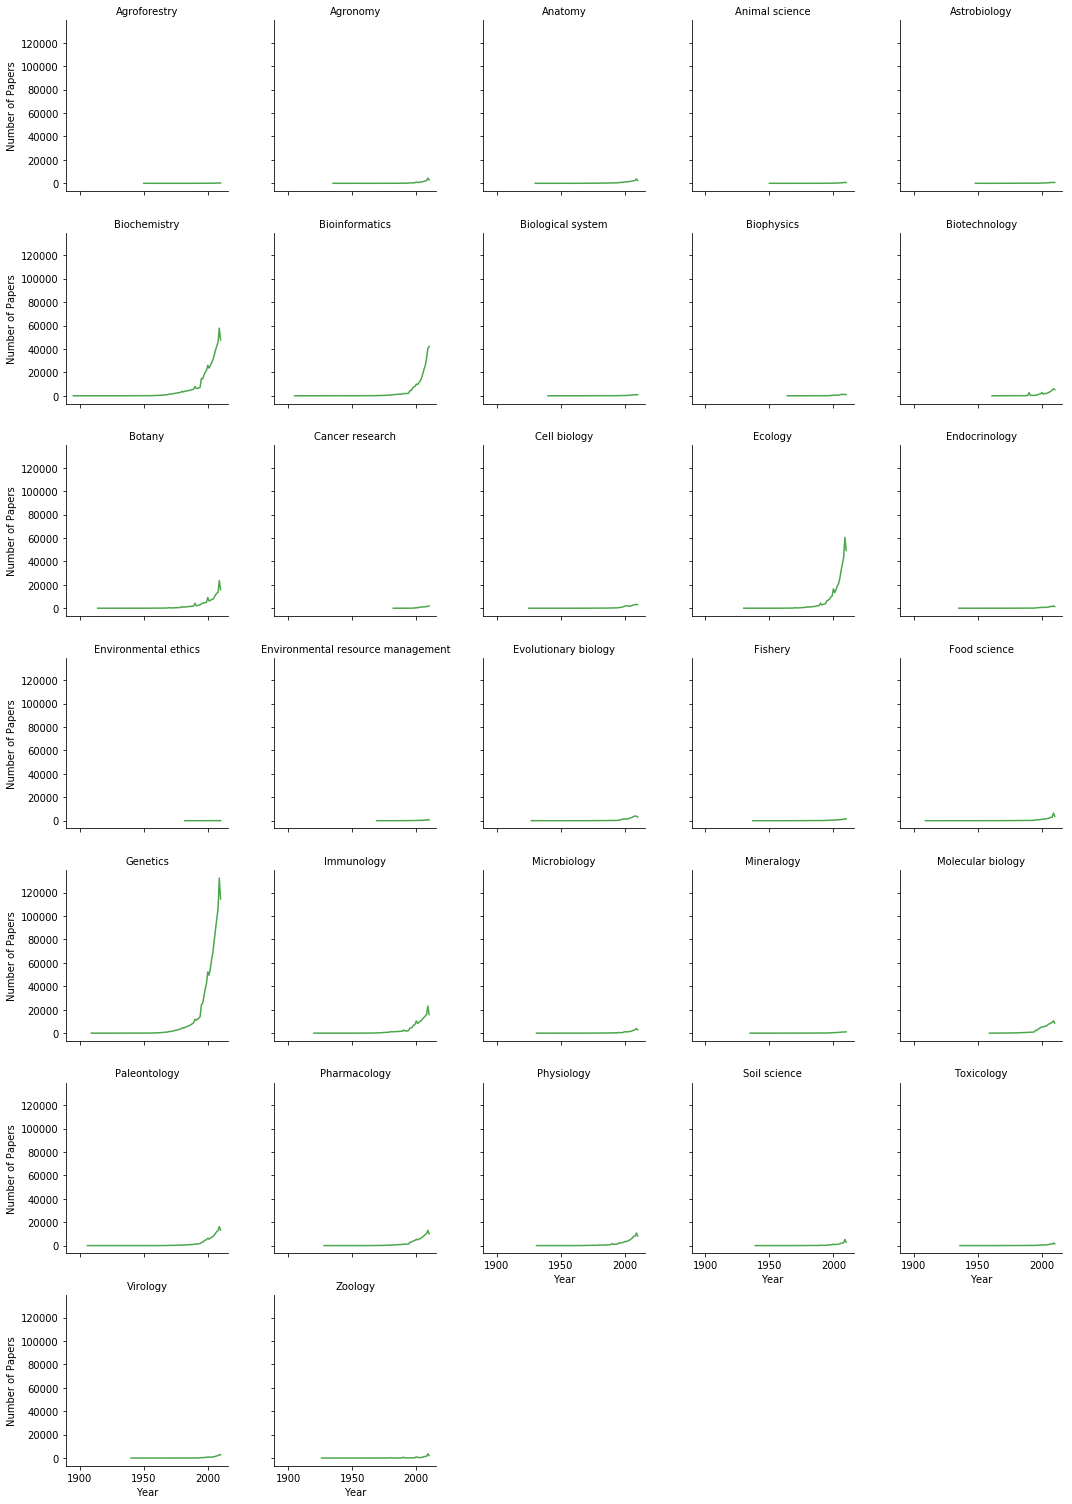

In [8]:
g = l1_bio_sframe.groupby(["Year", "L1 Field"], {"Number of Papers": agg.COUNT()})
df = g.to_dataframe()
df = df.sort_values(["L1 Field", "Year"])
c = sns.FacetGrid(df, col="L1 Field", sharex=True, sharey=True, col_wrap=5)
c.map(plt.plot, "Year", "Number of Papers", alpha=.7, color='g').set_titles("{col_name}")

From the above chart, we can observe that the various subfields of Biology have a large difference in the number of published papers. For example, in Genetics more than 114,532 papers were published in 2010, while in Virology the number of papers was only 2,597.

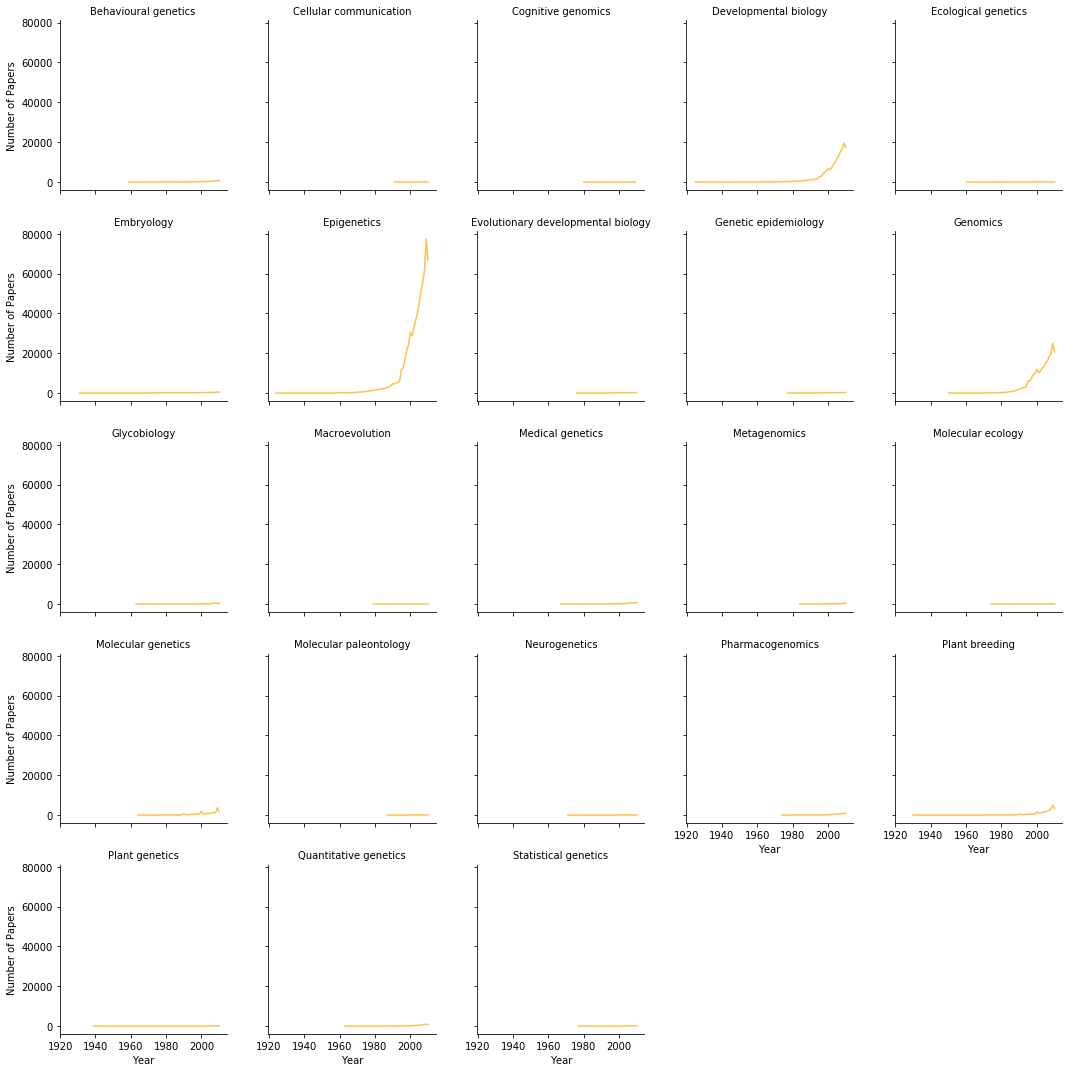

In [9]:
g = l2_gen_sframe.groupby(["Year", "L2 Field"], {"Number of Papers": agg.COUNT()})
df = g.to_dataframe()
df = df.sort_values(["L2 Field", "Year"])
c = sns.FacetGrid(df, col="L2 Field", sharex=True, sharey=True, col_wrap=5)
c.map(plt.plot, "Year", "Number of Papers", alpha=.7, color="orange").set_titles("{col_name}")

### 4.2  Number of Authors over Time

Let's measure the average number of authors over time for the various research fields.

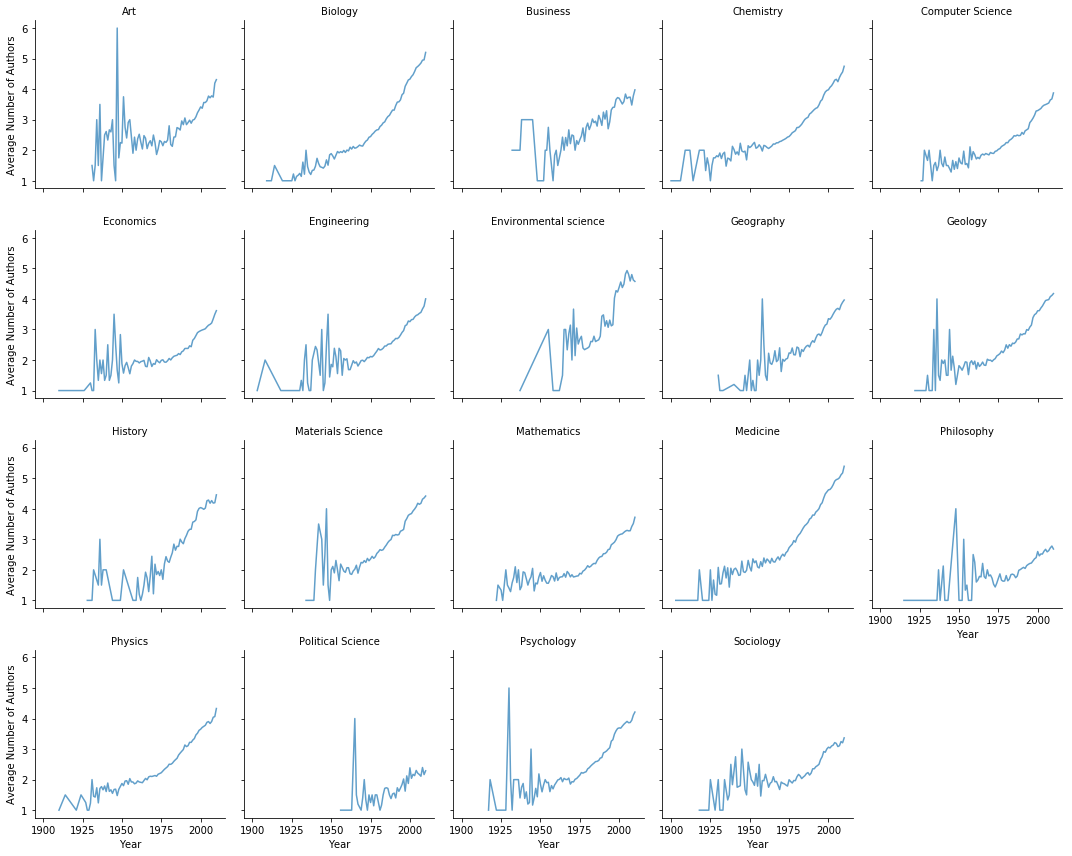

In [10]:
g = l0_sf.groupby(["Year", "L0 Field"], {"Average Number of Authors": agg.AVG("Authors Number")})
df = g.to_dataframe()
df = df.sort_values(["L0 Field", "Year"])
c = sns.FacetGrid(df, col="L0 Field", sharex=True, sharey=True, col_wrap=5)
c.map(plt.plot, "Year", "Average Number of Authors", alpha=.7).set_titles("{col_name}")

We can observe that across all research fields the average number of authors has increased sharply over the last century. However, while the average number of authors in Medicine and Biology is over 5 authors, in fields such as Political Science, Sociology, and Philosophy the average number of authors is about 3. Let's now observe how the average number of authors in Biology subfields has changed over time.

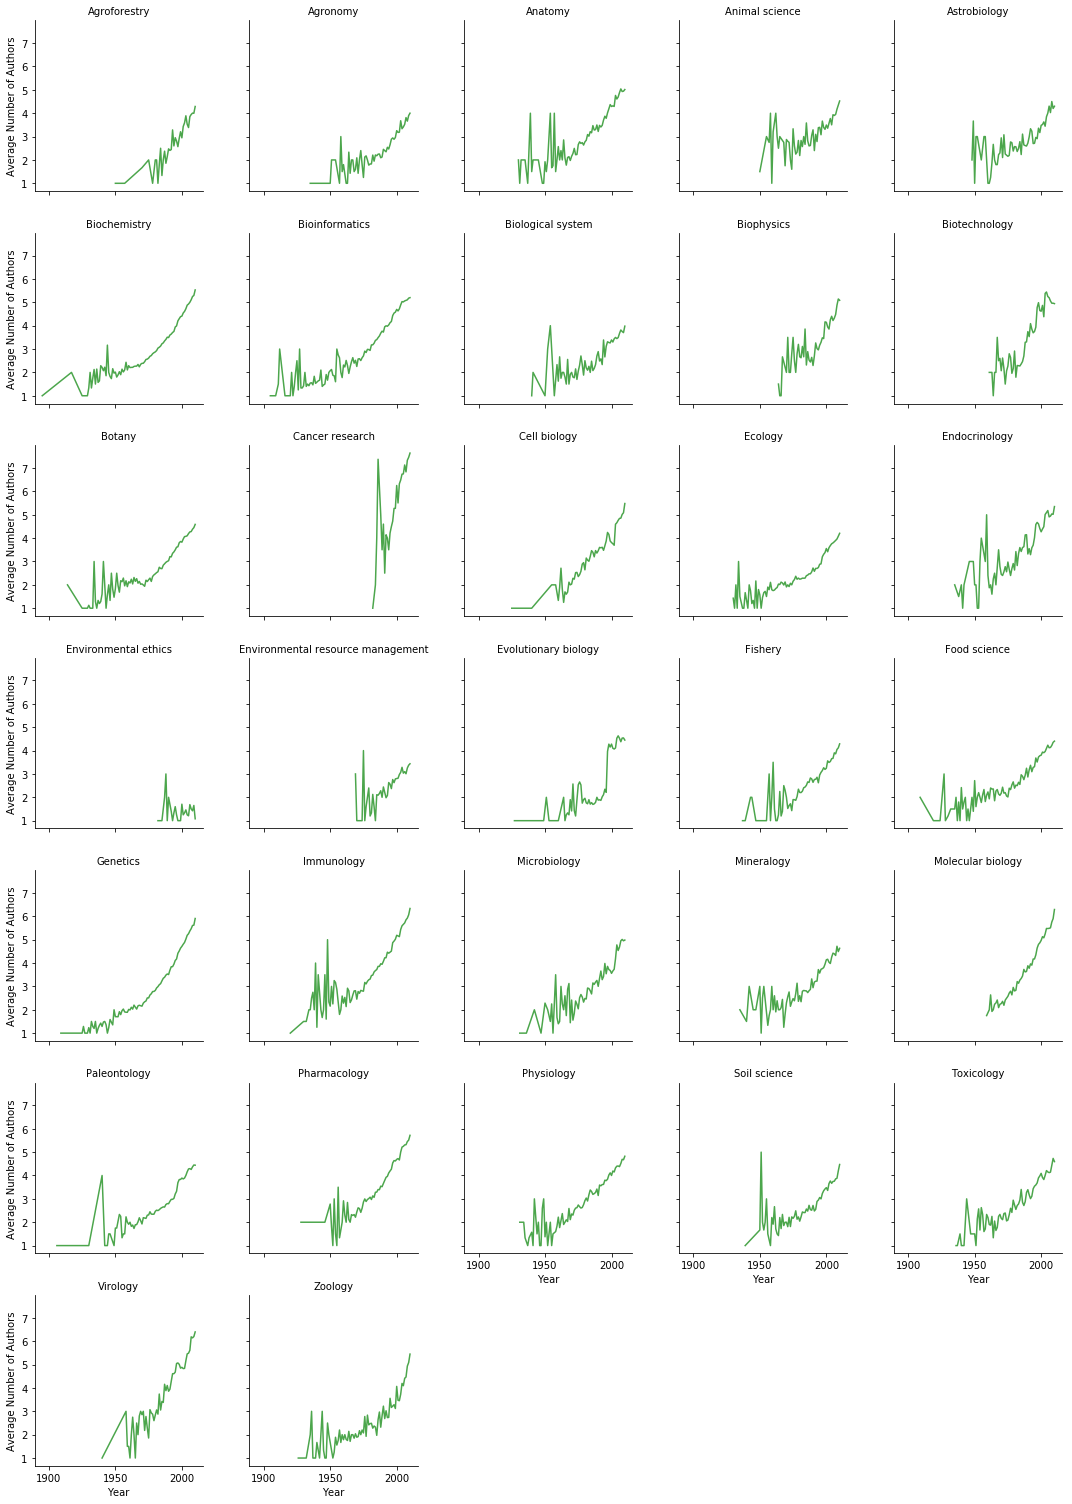

In [11]:
g = l1_bio_sframe.groupby(["Year", "L1 Field"], {"Average Number of Authors": agg.AVG("Authors Number")})
df = g.to_dataframe()
df = df.sort_values(["L1 Field", "Year"])
c = sns.FacetGrid(df, col="L1 Field", sharex=True, sharey=True, col_wrap=5)
c.map(plt.plot, "Year", "Average Number of Authors", alpha=.7,color='g').set_titles("{col_name}")

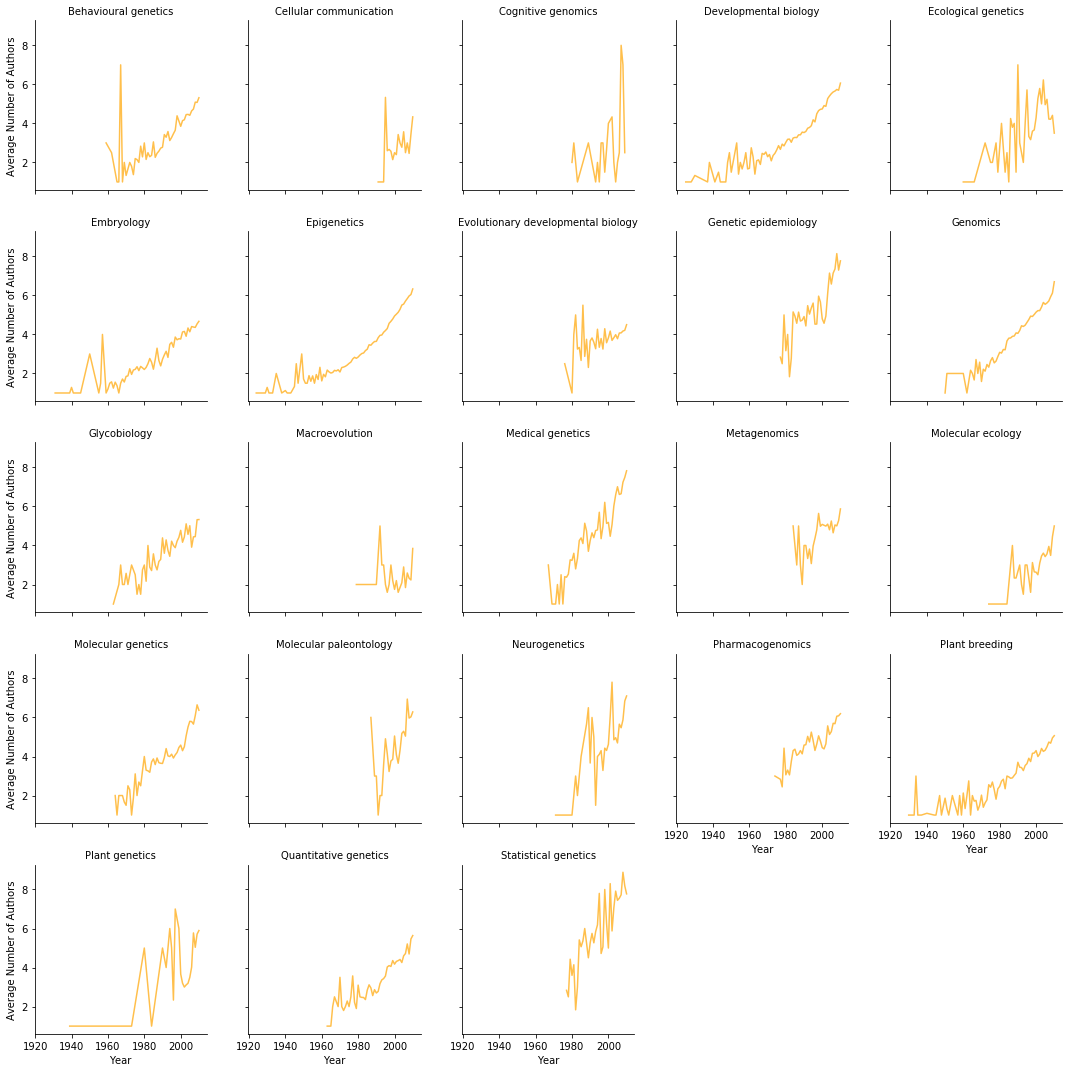

In [12]:
g = l2_gen_sframe.groupby(["Year", "L2 Field"], {"Average Number of Authors": agg.AVG("Authors Number")})
df = g.to_dataframe()
df = df.sort_values(["L2 Field", "Year"])
c = sns.FacetGrid(df, col="L2 Field", sharex=True, sharey=True, col_wrap=5)
c.map(plt.plot, "Year", "Average Number of Authors", alpha=.7, color="orange").set_titles("{col_name}")

We can also observe a wide diversity in the average number of authors in various Biology subfields.

### 4.3  Number of References over Time

Let's calculate the average number of references in the L0 research fields, and in the Biology subfields.

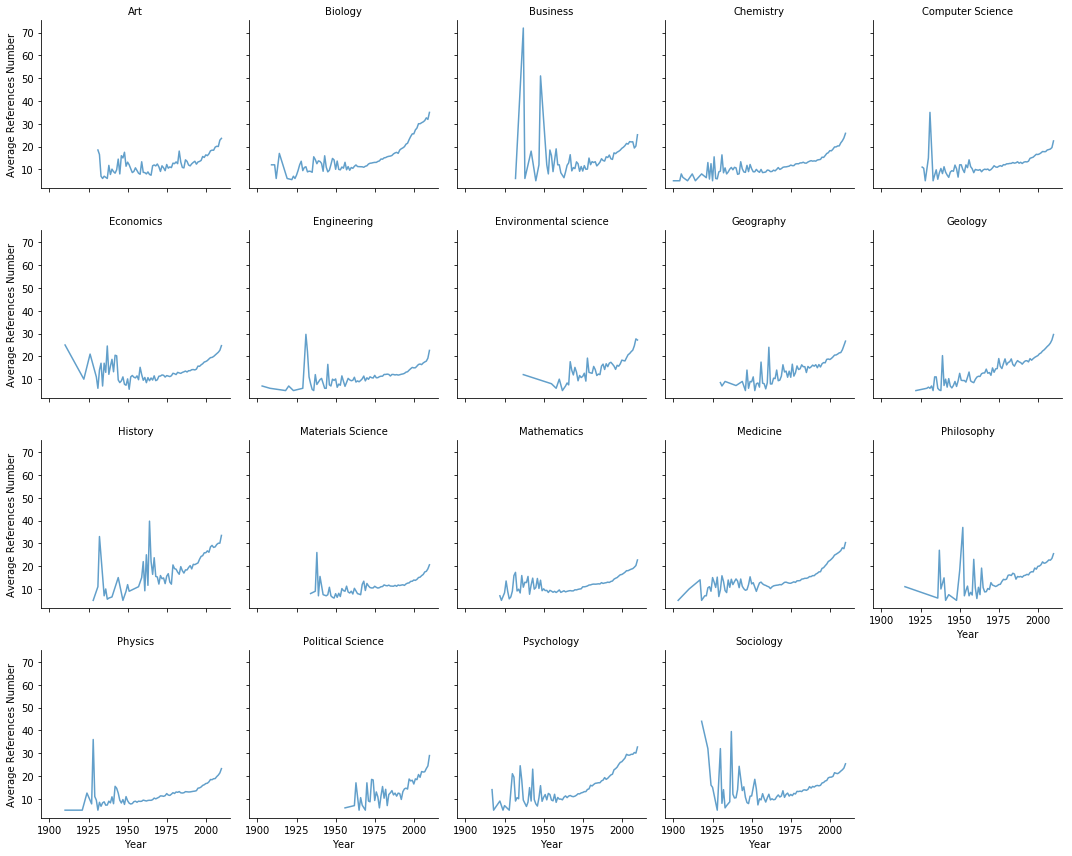

In [13]:
g = l0_sf.groupby(["Year", "L0 Field"], {"Average References Number": agg.AVG("Ref Number")})
df = g.to_dataframe()
df = df.sort_values(["L0 Field", "Year"])
c = sns.FacetGrid(df, col="L0 Field", sharex=True, sharey=True, col_wrap=5)
c.map(plt.plot, "Year", "Average References Number", alpha=.7).set_titles("{col_name}")

It seems that across all the research fields the average number of references per paper has increased sharply in recent years. However, there are research fields, such as Biology, in which the average number of references is above 30, while in other fields, such as Mathematics, the average number of references is about 20. Let's observe what the average number of references is in Biology subfields:

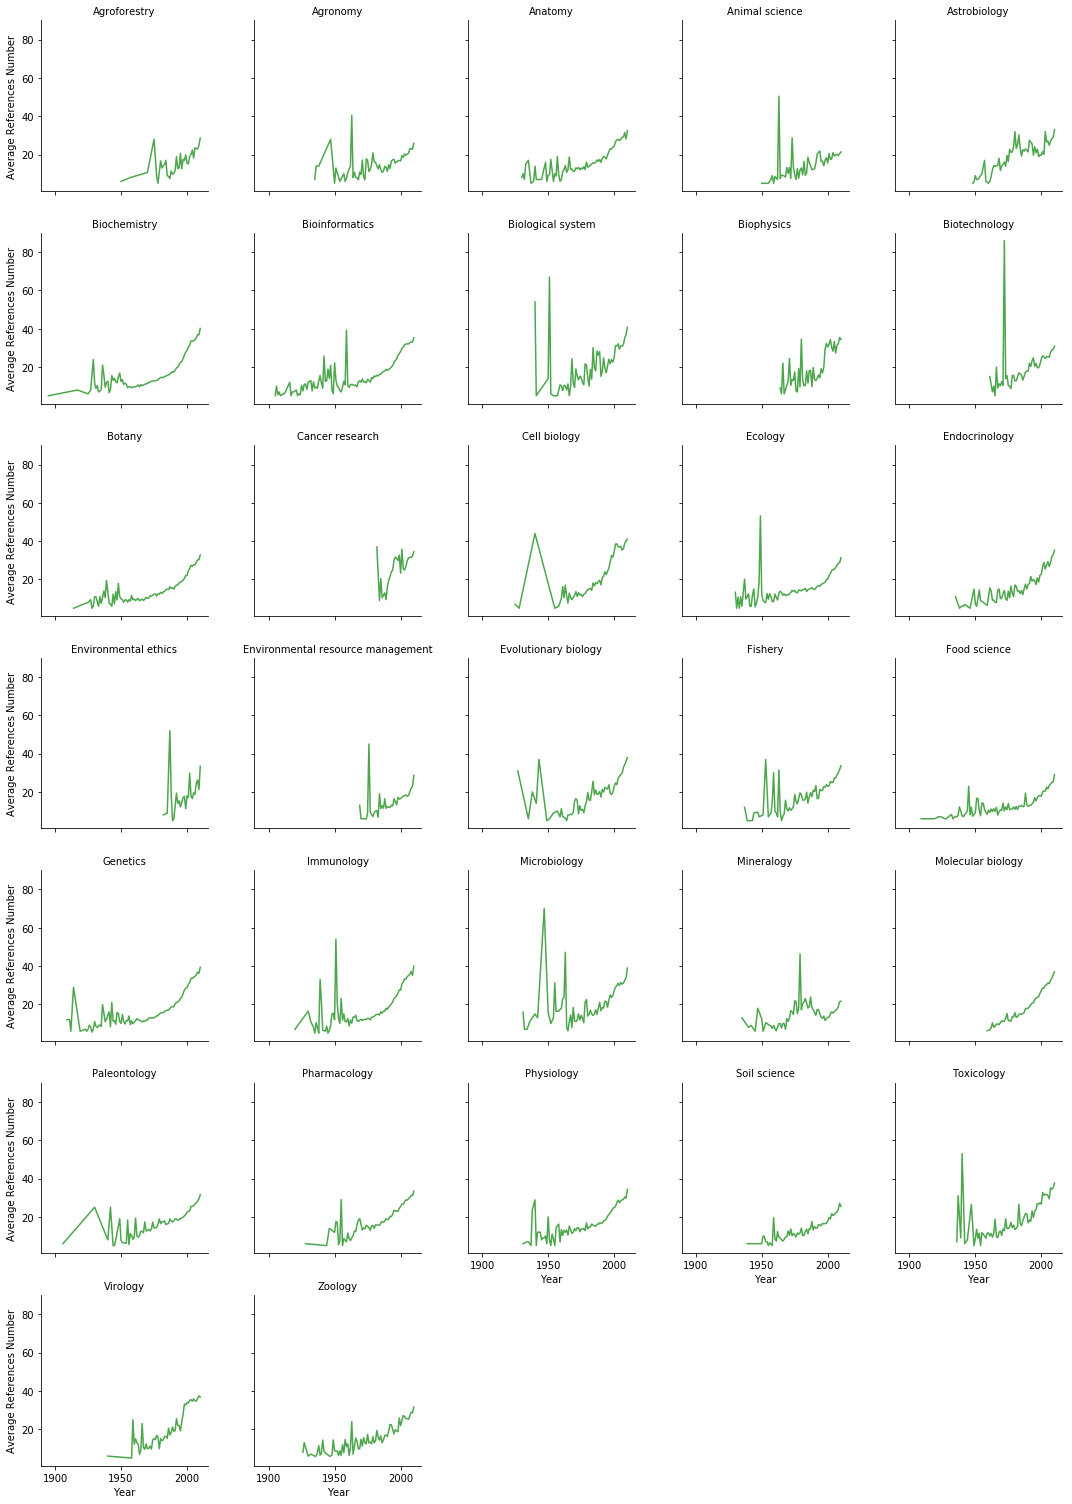

In [14]:
g = l1_bio_sframe.groupby(["Year", "L1 Field"], {"Average References Number": agg.AVG("Ref Number")})
df = g.to_dataframe()
df = df.sort_values(["L1 Field", "Year"])
c = sns.FacetGrid(df, col="L1 Field", sharex=True, sharey=True, col_wrap=5)
c.map(plt.plot, "Year", "Average References Number", alpha=.7, color="g").set_titles("{col_name}")

As in previous results, we can observe that the average number of references has considerably increased over all the Biology subfields. However, while papers in some subfields increased to over 40 references, papers in other subfields had many fewer references.

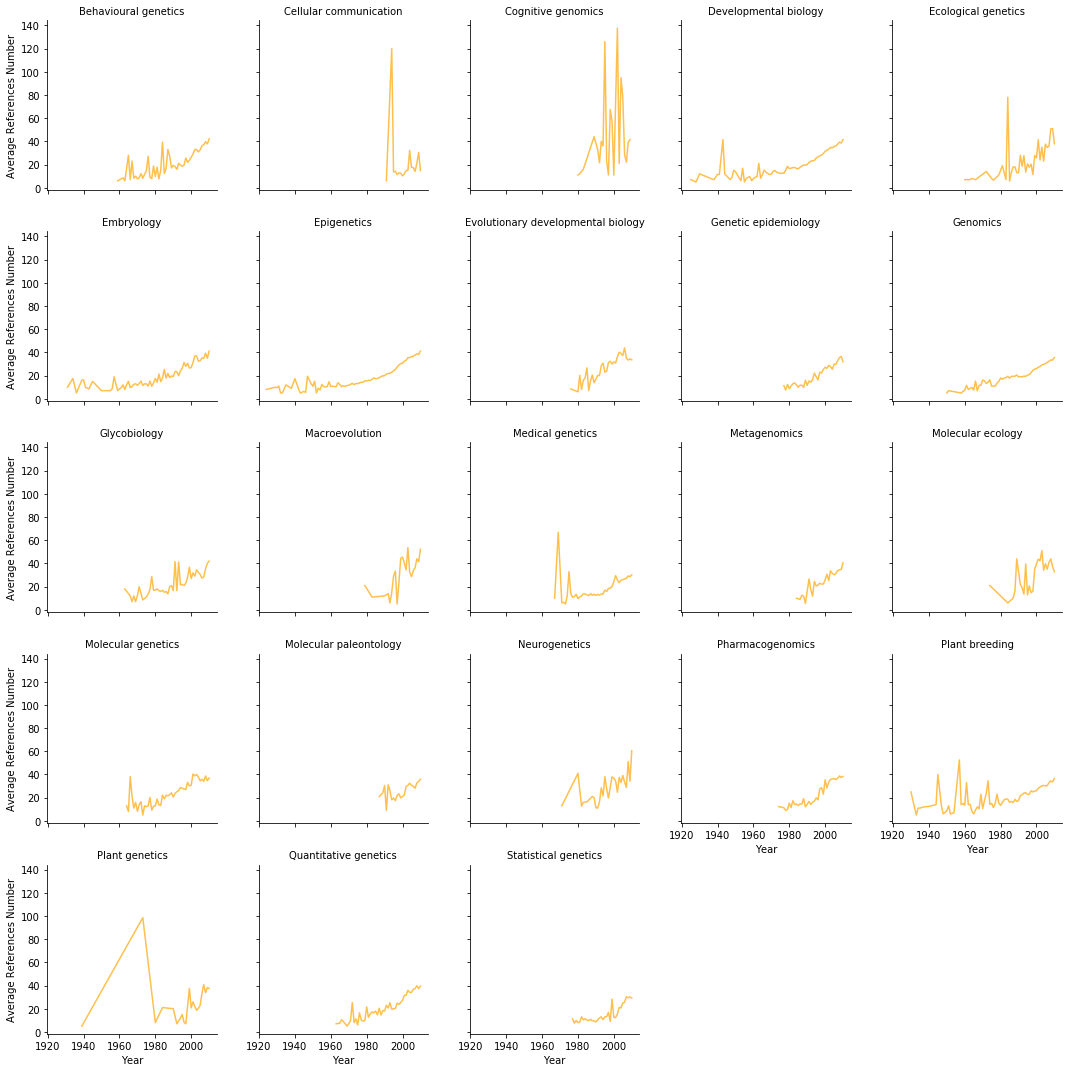

In [15]:
g = l2_gen_sframe.groupby(["Year", "L2 Field"], {"Average References Number": agg.AVG("Ref Number")})
df = g.to_dataframe()
df = df.sort_values(["L2 Field", "Year"])
c = sns.FacetGrid(df, col="L2 Field", sharex=True, sharey=True, col_wrap=5)
c.map(plt.plot, "Year", "Average References Number", alpha=.7,color="orange").set_titles("{col_name}")

### 4.4 Number of Citations over Time

Let's calculate the average and median number of citationsin the L0 research fields, and in the Biology subfields.

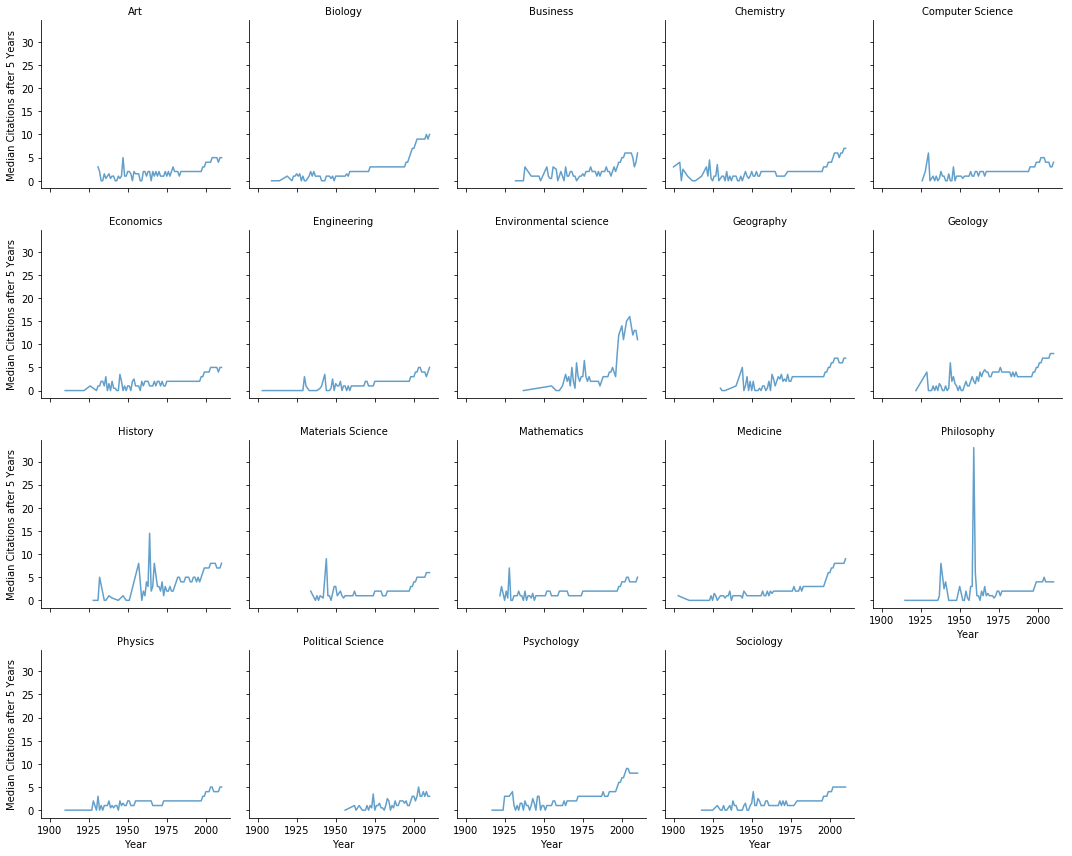

In [16]:
def citations_after_years(citations_dict, year, after_years=5):
    if citations_dict is None:
        return 0
    l = [v for k,v in citations_dict.iteritems() if (int(k) <= (year + after_years))] # it is about 5-6 years 
    if len(l) == 0:
        return 0
    return max(l)

l0_sf['Total Ciations After 5 Years'] = l0_sf.apply(lambda r: citations_after_years(r['Total Citations by Year'],
                                                                                   r["Year"], 5))


g = l0_sf.groupby(["Year", "L0 Field"], {"Average Citations after 5 Years": agg.AVG('Total Ciations After 5 Years'), 
                                         "Citations after 5 Years List": agg.CONCAT('Total Ciations After 5 Years')})
g["Median Citations after 5 Years"] = g["Citations after 5 Years List"].apply(lambda l: np.median(l))
g = g.remove_column("Citations after 5 Years List")
df = g.to_dataframe()
df = df.sort_values(["L0 Field", "Year"])
c = sns.FacetGrid(df, col="L0 Field", sharex=True, sharey=True, col_wrap=5)
c.map(plt.plot, "Year", "Median Citations after 5 Years", alpha=.7).set_titles("{col_name}")

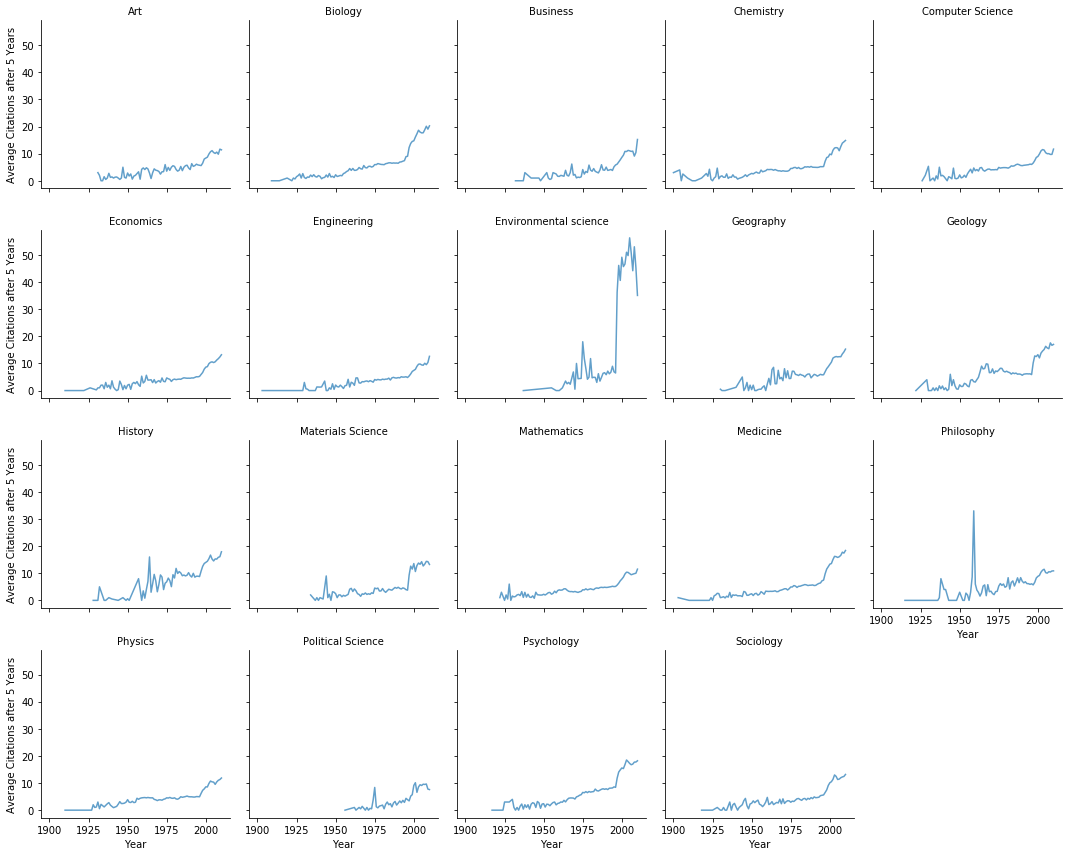

In [17]:
c = sns.FacetGrid(df, col="L0 Field", sharex=True, sharey=True, col_wrap=5)
c.map(plt.plot, "Year", "Average Citations after 5 Years", alpha=.7).set_titles("{col_name}")

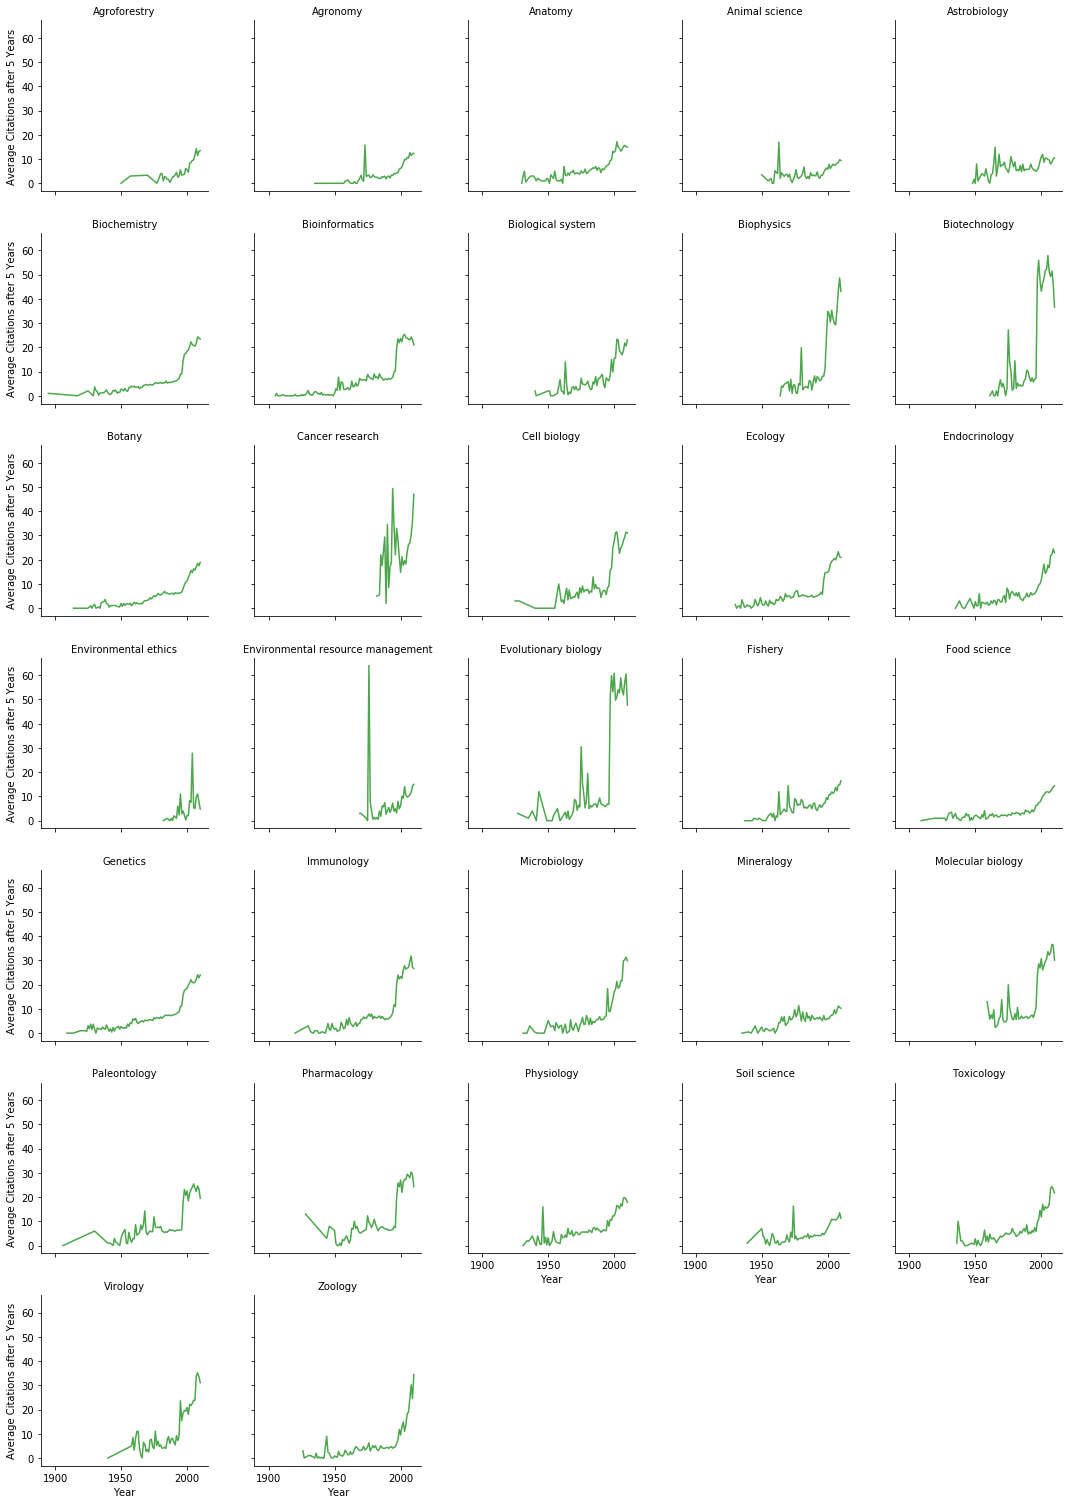

In [18]:
l1_bio_sframe['Total Ciations After 5 Years'] = l1_bio_sframe.apply(lambda r: citations_after_years(r['Total Citations by Year'],
                                                                                   r["Year"], 5))

g = l1_bio_sframe.groupby(["Year", "L1 Field"], {"Average Citations after 5 Years": agg.AVG('Total Ciations After 5 Years'),
                                                 "Citations after 5 Years List": agg.CONCAT('Total Ciations After 5 Years')
                                                })
g["Median Citations after 5 Years"] = g["Citations after 5 Years List"].apply(lambda l: np.median(l))
g = g.remove_column("Citations after 5 Years List")
df = g.to_dataframe()
df = df.sort_values(["L1 Field", "Year"])
c = sns.FacetGrid(df, col="L1 Field", sharex=True, sharey=True, col_wrap=5)
c.map(plt.plot, "Year", "Average Citations after 5 Years", alpha=.7,color="g").set_titles("{col_name}")

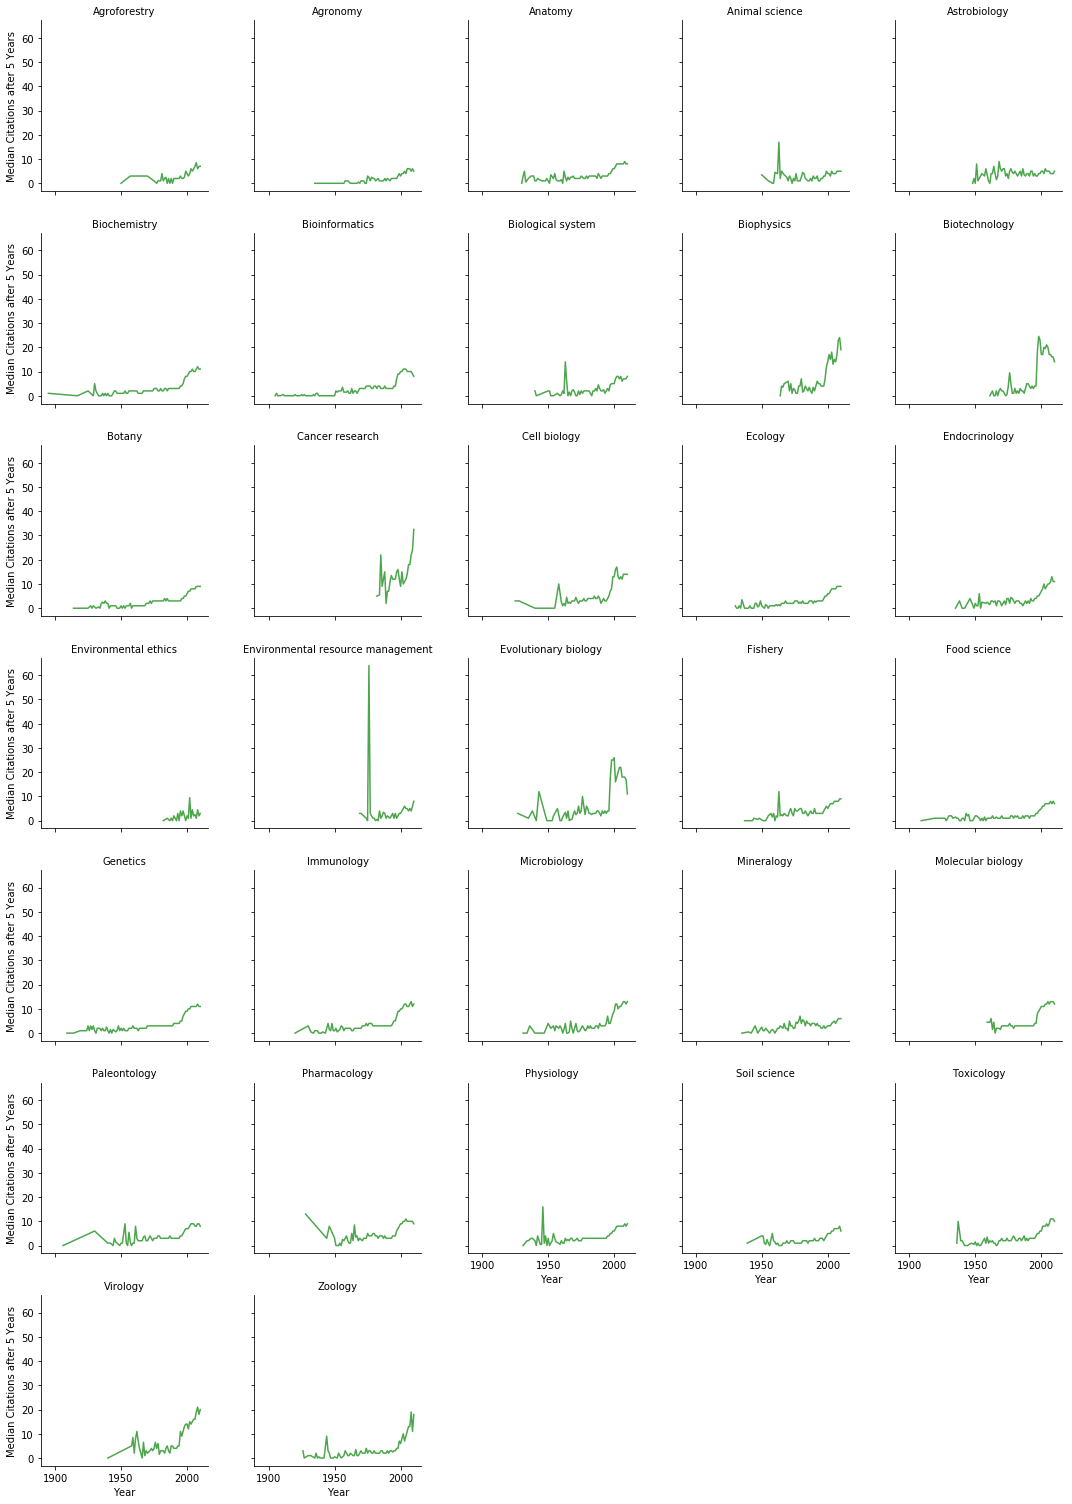

In [19]:
c = sns.FacetGrid(df, col="L1 Field", sharex=True, sharey=True, col_wrap=5)
c.map(plt.plot, "Year", "Median Citations after 5 Years", alpha=.7,color="g").set_titles("{col_name}")

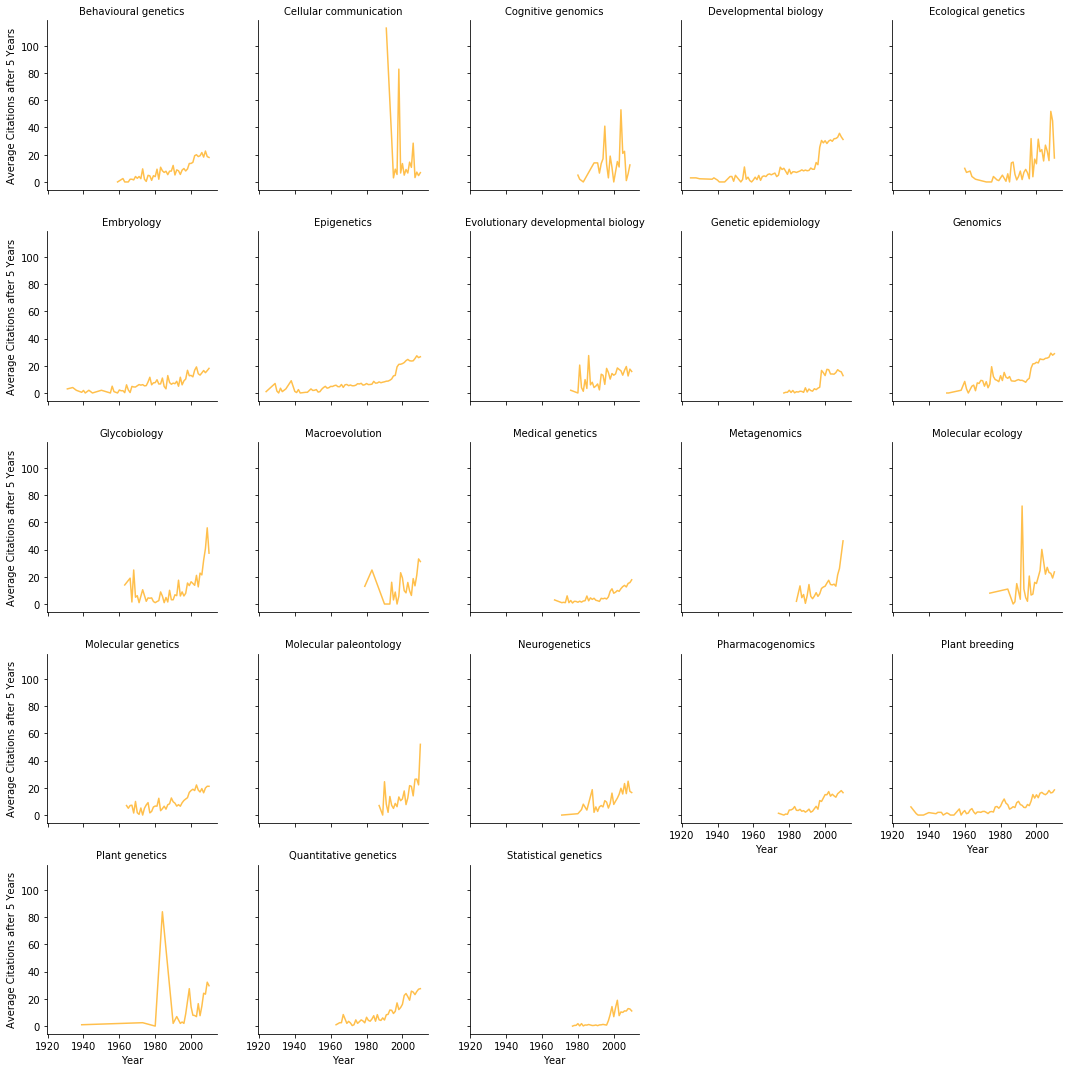

In [20]:
l2_gen_sframe['Total Ciations After 5 Years'] = l2_gen_sframe.apply(lambda r: citations_after_years(r['Total Citations by Year'],
                                                                                   r["Year"], 5))

g = l2_gen_sframe.groupby(["Year", "L2 Field"], {"Average Citations after 5 Years": agg.AVG('Total Ciations After 5 Years'),
                                                 "Citations after 5 Years List": agg.CONCAT('Total Ciations After 5 Years')
                                                })
g["Median Citations after 5 Years"] = g["Citations after 5 Years List"].apply(lambda l: np.median(l))
g = g.remove_column("Citations after 5 Years List")
df = g.to_dataframe()
df = df.sort_values(["L2 Field", "Year"])
c = sns.FacetGrid(df, col="L2 Field", sharex=True, sharey=True, col_wrap=5)
c.map(plt.plot, "Year", "Average Citations after 5 Years", alpha=.7,color="orange").set_titles("{col_name}")

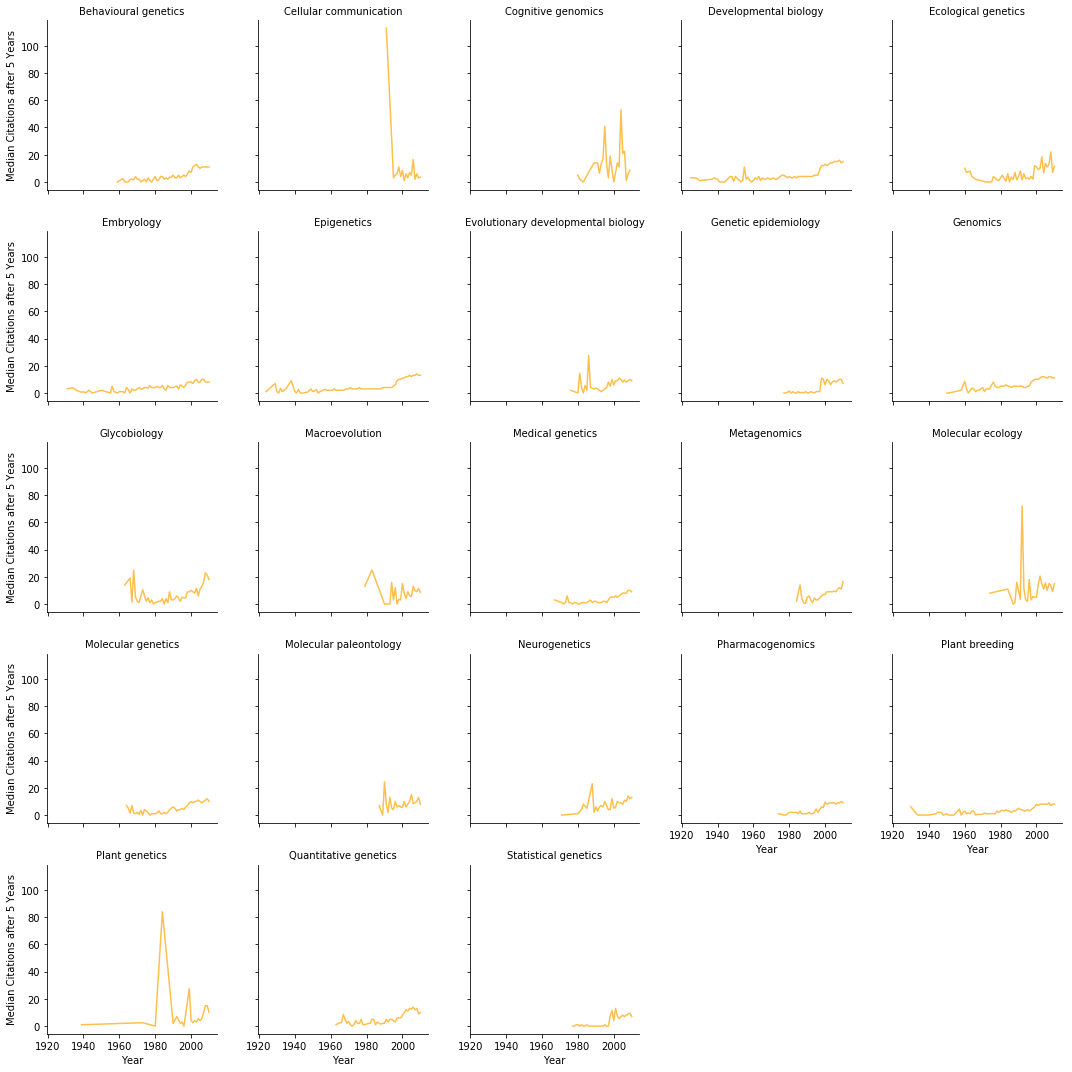

In [21]:
c = sns.FacetGrid(df, col="L2 Field", sharex=True, sharey=True, col_wrap=5)
c.map(plt.plot, "Year", "Median Citations after 5 Years", alpha=.7,color="orange").set_titles("{col_name}")

In [22]:
l3_fields_sf = tc.load_sframe(EXTENDED_PAPERS_SFRAME)["Paper ID", "Paper publish year",
                                                    'Fields of study parent list (L3)',
                                                   "Ref Number", "Authors Number", "Total Citations by Year"]
l3_fields_sf = l3_fields_sf.rename({"Paper publish year": "Year"})
l3_fields_sf = l3_fields_sf[l3_fields_sf['Fields of study parent list (L3)'] != None]
l3_fields_sf = l3_fields_sf[l3_fields_sf['Fields of study parent list (L3)'].apply(lambda l: len(l) <= 100)] # remove papers that belong to more than 10 fields
l3_fields_sf = l3_fields_sf[l3_fields_sf["Ref Number"] >= 5]
l3_fields_sf.materialize()

In [23]:
l3_fields_sf = filter_sframe_by_years(l3_fields_sf, 2009, 2009)
l3_fields_sf =  l3_fields_sf.stack("Fields of study parent list (L3)", new_column_name="L3 Field ID")
l3_fields_sf = l3_fields_sf[l3_fields_sf['Total Citations by Year'] != None]
l3_fields_sf['Citations After 5 Years'] = l3_fields_sf.apply(lambda r: citations_after_years(r['Total Citations by Year'],
                                                                                   r["Year"], 5))

In [24]:
sf = l3_fields_sf["Paper ID","Year", "Authors Number","Citations After 5 Years", "L3 Field ID" ]
g = sf.groupby("L3 Field ID", { "Papers Number": agg.COUNT_DISTINCT("Paper ID"),
                                "Average Author Number": agg.AVG("Authors Number"),
                               "Citations After 5-years List": agg.CONCAT("Citations After 5 Years"),
                               "MAX Citations After 5-years": agg.MAX("Citations After 5 Years")
                               
                              })
g = g[g["Papers Number"] >= 100] # selecting only L3 fields with at least 100 cited papers in 2009
g["Median Citations After 5-years"] = g["Citations After 5-years List"].apply(lambda l: round(np.median(l),2))
h = tc.load_sframe(FIELDS_OF_STUDY_SFRAME)
g = g.join(h, on={'L3 Field ID': 'Field of study ID'})
h2 = tc.load_sframe(FIELDS_OF_STUDY_HIERARCHY_SFRAME)
h2 = h2[h2['Child field of study level'] == "L3"]
h2 = h2[h2['Parent field of study level'] == "L0"]
h2 = h2[h2['Confidence'] >= 0.95]
g = g.join(h2, on={'L3 Field ID': 'Child field of study ID'})
g = g.join(h, on={"Parent field of study ID": 'Field of study ID' })
g = g.rename({"Field of study name.1": "Parent Field of Study"})
g = g["Parent Field of Study", "Field of study name", "Median Citations After 5-years", "MAX Citations After 5-years", "Papers Number", "Average Author Number" ]
g["MAX Citations After 5-years"] = g["MAX Citations After 5-years"].apply(lambda i: int(i))
g["Average Author Number"] = g["Average Author Number"].apply(lambda i: round(i,2))
g = g.sort(["Parent Field of Study", "Median Citations After 5-years"])

In [25]:
# Save to file
#html = g.to_dataframe().to_html()
#file(u'/mnt/data/fields_stat.html', 'wb').write(html.encode('utf8'))
g

Parent Field of Study,Field of study name,Median Citations After5-years ...,MAX Citations After5-years ...,Papers Number,Average Author Number
Art,Publication,4.0,100,164,3.38
Art,Etching,4.0,124,285,5.35
Art,Video,4.5,72,170,3.48
Art,Music,5.0,204,479,2.83
Art,Clothing,5.0,72,123,3.86
Art,Film,5.0,252,857,4.11
Art,Physical model,6.0,147,452,3.77
Art,Conceptual design,6.0,51,184,4.39
Art,Photography,8.0,158,201,3.7
Art,Performance,9.0,473,1467,4.08


In [26]:
g.sort("Median Citations After 5-years", ascending=True)

Parent Field of Study,Field of study name,Median Citations After5-years ...,MAX Citations After5-years ...,Papers Number,Average Author Number
Mathematics,Finite impulse response,2.0,167,337,3.0
Computer Science,Pixel,2.0,380,2484,3.27
Computer Science,Ontology,2.0,616,733,3.35
Computer Science,Mesh networking,2.0,62,274,3.43
Computer Science,Camera resectioning,2.0,43,114,3.13
Computer Science,Session InitiationProtocol ...,2.0,116,100,3.6
Chemistry,Gallium,2.0,73,484,3.43
Mathematics,Presentation of a group,2.0,91,706,3.22
Mathematics,Spiral,2.0,80,122,3.65
Mathematics,Block code,2.0,54,281,2.83


[Text(0.5,0,u'L3 Subfields Median Citations After 5-Years')]

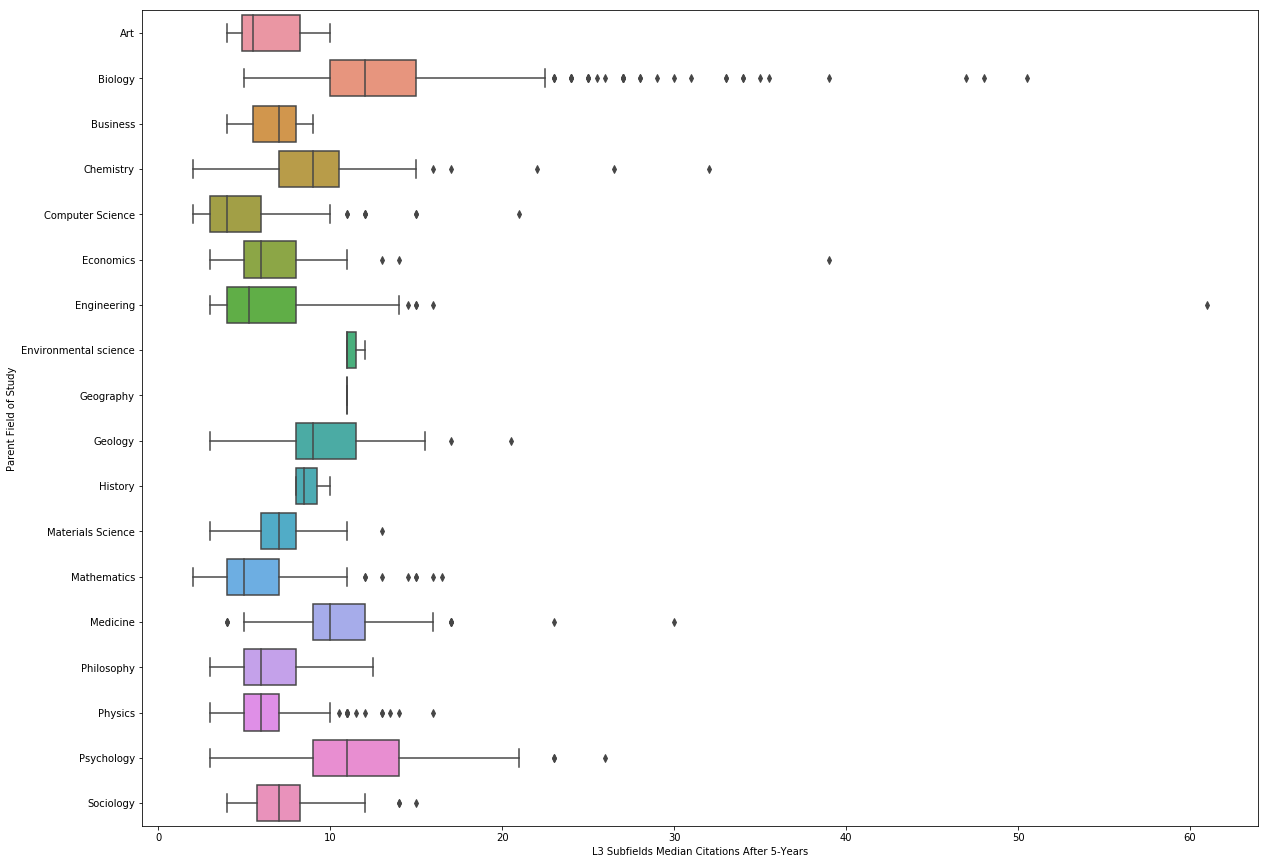

In [27]:
plt.subplots(figsize=(20,15))
s = sns.boxplot(y="Parent Field of Study", x="Median Citations After 5-years", data=g.to_dataframe(), orient="h")
s.set(xlabel='L3 Subfields Median Citations After 5-Years')

As in previous results, we can observe that the average/median number of citaitons have considerably increased over all the Biology subfields. However, as can be observed from the above resutls, different research domains have different average and median number of citations.

Overall, in our analysis, we discovered that different domains had a wide range of properties that evolved differently over time.